In [1]:
import tensorflow as tf
import modules.layers as tf_util
import modules.utility as util
import numpy as np
import tables
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from IPython.display import display, Javascript
from sklearn.metrics import precision_recall_curve
from medpy.metric.binary import hd, assd,dc,precision
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['font.size'] = 13

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

def disable_scroll():
    display(Javascript(disable_js))
    print ("autoscrolling long output is disabled")
    
disable_scroll()

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

def reorder_contour(c):
    N = len(c)
    even_inds = np.arange(0,N,2)
    odd_inds = np.arange(1,N,2)
    
    even_points = np.asarray([c[i] for i in even_inds])
    odd_points = np.asarray([c[i] for i in odd_inds])
    
    N_even = len(even_points)
    ret = np.zeros_like(c)
    ret[:N_even] = even_points
    ret[N_even:] = np.flipud(odd_points)
    ret = ret[:-2]
    return ret.copy()

Using TensorFlow backend.


<IPython.core.display.Javascript object>

autoscrolling long output is disabled


In [2]:
mhas = open('images.txt').readlines()
mhas = [i.replace('\n','') for i in mhas]
# mhas = [i.split('/')[-1] for i in mhas]
# mhas = ['./data/'+i for i in mhas]

truths = open('truths.txt').readlines()
truths = [i.replace('\n','') for i in truths]

paths = open('paths.txt').readlines()
paths = [i.replace('\n','') for i in paths]

groups = open('groups.txt').readlines()
groups = [i.replace('\n','') for i in groups]

ct_test = open('ct_test.txt').readlines()
ct_test = [i.replace('\n','') for i in ct_test]

test_images = []
for i in range(len(mhas)):
    if any([c in mhas[i] for c in ct_test]):
        test_images.append((mhas[i],truths[i],paths[i],groups[i]))
        
print test_images

[('/home/marsdenlab/datasets/vascular_data/OSMSC0004/OSMSC0004-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0004/0004_0001/0004_0001_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0113/OSMSC0113-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0113/0113_0003/0113_0003-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0113/0113_0003/0113_0003-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0113/0113_0003/0113_0003_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0118/OSMSC0118-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0118/0118_1000/0118_1000-cm.mha', '/home/marsdenlab/datasets/vascular_data/OSMSC0118/0118_1000/0118_1000-cm.paths', '/home/marsdenlab/datasets/vascular_data/OSMSC0118/0118_1000/0118_1000_groups-cm'), ('/home/marsdenlab/datasets/vascular_data/OSMSC0

In [3]:
#######################################################
# Get data
#######################################################
data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'
test = data_path+'test_192_ct.hdf5'
f_test = tables.open_file(test)


In [4]:
N,W,H,C = f_test.root.X.shape
#C_truth = [util.marchingSquares(y.astype(np.float32),iso=0.5,mode='center') for y in f_test.root.Y[:,:,:,0]]
crop_dims = 128
print f_test.root.meta.shape
print f_test.root.meta[0]
Y = np.asarray(f_test.root.Y)
Y = Y.astype(int)

(31588, 2)
[ 0.05859375  0.05859375]


In [5]:
Y = util.crop_center_nd(Y,crop_dims, crop_dims)

31588
[[ -1.29760742e-01   1.15633011e-05]
 [ -1.23840332e-01  -4.02221680e-02]
 [ -1.07238770e-01  -7.78808594e-02]
 [ -7.95288086e-02  -1.09497070e-01]
 [ -4.24804688e-02  -1.30737305e-01]
 [  8.34465027e-07  -1.38549805e-01]
 [  4.27246094e-02  -1.31469727e-01]
 [  8.04443359e-02  -1.10717773e-01]
 [  1.08703613e-01  -7.89794922e-02]
 [  1.25122070e-01  -4.06799316e-02]
 [  1.29760742e-01  -0.00000000e+00]
 [  1.23901367e-01   4.02526855e-02]
 [  1.07238770e-01   7.78808594e-02]
 [  7.95898438e-02   1.09497070e-01]
 [  4.24804688e-02   1.30737305e-01]
 [ -9.53674316e-07   1.38427734e-01]
 [ -4.27551270e-02   1.31591797e-01]
 [ -8.04443359e-02   1.10717773e-01]
 [ -1.08764648e-01   7.89794922e-02]
 [ -1.25122070e-01   4.06494141e-02]]


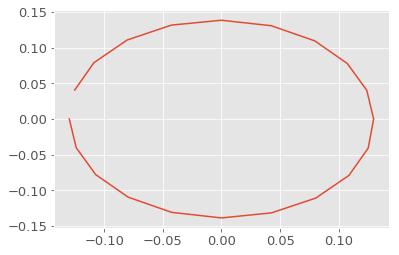

In [6]:
C_truth = f_test.root.C[:N]
print len(C_truth)
print C_truth[0]

plt.figure()
plt.plot(C_truth[0][:,0],C_truth[0][:,1])
plt.show()
plt.close()
# np.save('truth_conts_ct.npy',C_truth)

In [7]:
def calc_errors(err_dict,pred_dict,c_truth,y_truth,meta,code):
    
    err_dict[code] = {}
    
    y = util.threshold(pred_dict[code]['y'],0.2).astype(int)
    c = pred_dict[code]['c']
    
    N = len(y)
    Ntruth = len(y_truth)
   
    if not N == Ntruth:
        raise RuntimeError('number of predicted and true segs does not match {},{}'.format(N,Ntruth))
    
    Nc = len(pred_dict[code]['c'])
    Nc_truth = len(c_truth)

    if not Nc == Nc_truth:
        raise RuntimeError('number of predicted and true conts does not match {},{}'.format(Nc,Nc_truth))

    print "Error calc {} y {}, y_truth {}, c {}, c_truth {}".format(code,y.shape,y_truth.shape,len(c),len(c_truth))

    #JACCARD
    err_dict[code]['jaccard'] = util.listAreaOverlapError(c,c_truth)

    #HAUSDORF
    err_dict[code]['hausdorf'] = []
    for i in range(N):
        if np.sum(y_truth[i]) > 0.1:
            if np.sum(y[i])>0.1:
                e = hd(y[i,:,:,0], y_truth[i,:,:,0], meta[i][0])
                err_dict[code]['hausdorf'].append(e)

    #ASSD
    err_dict[code]['assd'] = [] 

    for i in range(N):
        if np.sum(y_truth[i]) > 0.1:
            if np.sum(y[i])>0.1:
                e = assd(y[i,:,:,0],y_truth[i,:,:,0],f_test.root.meta[i][0])
                err_dict[code]['assd'].append(e)

    #DICE
    err_dict[code]['dice'] = [] 

    for i in range(N):
        if np.sum(y_truth[i]) > 0.1:
            if np.sum(y[i])>0.1:
                e = dc(y[i,:,:,0],y_truth[i,:,:,0])
                err_dict[code]['dice'].append(e)
    
    y = pred_dict[code]['y'].astype(float)
    
    #precision recall
    err_dict[code]['pr'] = precision_recall_curve(np.ravel(y_truth),np.ravel(y))
                
def get_preds(pred_dict,ct_c,ct_y,mr_c,mr_y,code):
    pred_dict[code] = {}
    pred_dict[code]['y'] = np.load(ct_y)

    pred_dict[code]['c'] = np.load(ct_c)
    
#     pred_dict[code]['y'] = np.concatenate((pred_dict[code]['y'], np.load(mr_y)))

#     pred_dict[code]['c'] = np.concatenate((pred_dict[code]['c'],np.load(mr_c)))
    
    print "segs and contours for {}, y shape = {}, c shape = {}".format(code,pred_dict[code]['y'].shape,
                                                                    pred_dict[code]['c'].shape)

In [8]:
PREDS = {}
ERRORS = {}

code = 'i2ifc'
ct_c = 'i2i_conts_CT.npy'
ct_y = 'i2i_segs_CT.npy'
mr_c = 'i2i_conts_ct.npy'
mr_y = 'i2i_segs_ct.npy'

c_truth = C_truth
y_truth = Y

print len(y_truth),len(c_truth)
get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code)

#NOTE ADDING 32 BECAUSE EXTRACTED FROM CROPPED IMAGES
PREDS[code]['c'] = [c[:,:2]-64 for c in PREDS[code]['c']]
PREDS[code]['c'] = [PREDS[code]['c'][i]*f_test.root.meta[i] for i in  range(len(C_truth))]
PREDS[code]['c'] = [reorder_contour(c) for c in PREDS[code]['c']]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,f_test.root.meta,code)

31588 31588
segs and contours for i2ifc, y shape = (31588, 128, 128, 1), c shape = (31588,)
i2ifc shape = y (31588, 128, 128, 1), c 31588, (38, 2)
Error calc i2ifc y (31588, 128, 128, 1), y_truth (31588, 128, 128, 1), c 31588, c_truth 31588


In [9]:
code = 'i2i'
ct_c = 'i2i_vanilla_conts_ct.npy'
ct_y = 'i2i_vanilla_segs_ct.npy'
mr_c = 'i2i_vanilla_conts_mr.npy'
mr_y = 'i2i_vanilla_segs_mr.npy'

c_truth = C_truth
y_truth = Y

get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code)

#NOTE ADDING 32 BECAUSE EXTRACTED FROM CROPPED IMAGES
PREDS[code]['c'] = [c[:,:2]-64 for c in PREDS[code]['c']]
PREDS[code]['c'] = [PREDS[code]['c'][i]*f_test.root.meta[i] for i in  range(len(C_truth))]
PREDS[code]['c'] = [reorder_contour(c) for c in PREDS[code]['c']]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,f_test.root.meta,code)

segs and contours for i2i, y shape = (31588, 128, 128, 1), c shape = (31588,)
i2i shape = y (31588, 128, 128, 1), c 31588, (22, 2)
Error calc i2i y (31588, 128, 128, 1), y_truth (31588, 128, 128, 1), c 31588, c_truth 31588


In [10]:
f_i2i3d = tables.open_file('/media/marsdenlab/Data2/datasets/DeepLofting/test_192_ct_i2i3d.hdf5')
code = 'i2i3d'
PREDS[code] = {}
PREDS[code]['y'] = f_i2i3d.root.X
PREDS[code]['c'] = np.load('i2i_3d_conts_ct.npy')
print len(PREDS[code]['c'])

c_truth = f_i2i3d.root.C[0:len(PREDS[code]['c'])]
y_truth = np.asarray(f_i2i3d.root.Y).astype(int)
meta = f_i2i3d.root.meta

print len(y_truth),len(c_truth),len(meta)
# get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code)

PREDS[code]['y'] = util.crop_center_nd(PREDS[code]['y'], crop_dims, crop_dims)
y_truth = util.crop_center_nd(y_truth, crop_dims, crop_dims)

#NOTE ADDING 32 BECAUSE EXTRACTED FROM CROPPED IMAGES
PREDS[code]['c'] = [c[:,:2]-96 for c in PREDS[code]['c']]
PREDS[code]['c'] = [PREDS[code]['c'][i]*meta[i] for i in  range(len(c_truth))]
PREDS[code]['c'] = [reorder_contour(c) for c in PREDS[code]['c']]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,f_i2i3d.root.meta,code)

30288
30288 30288 30288
i2i3d shape = y (30288, 128, 128, 1), c 30288, (30, 2)
Error calc i2i3d y (30288, 128, 128, 1), y_truth (30288, 128, 128, 1), c 30288, c_truth 30288


In [11]:

code = 'drls'
ct_c = 'drls_conts_ct.npy'
ct_y = 'drls_segs_ct.npy'
mr_c = 'drls_conts_mr.npy'
mr_y = 'drls_segs_mr.npy'

c_truth = C_truth
y_truth = Y

get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code)

#post processing
tmp = []
for i in range(N):

    c = PREDS[code]['c'][i]
    if len(c.shape) == 1:
        c = np.asarray([[0,0,0],[0,0,0]])
        
    c = c[:,:2]
    r = reorder_contour(c)
    r = r-96
    r = r*f_test.root.meta[i]
    tmp.append(r)
PREDS[code]['c'] = tmp

#crop dims
PREDS[code]['y'] = util.crop_center_nd(PREDS[code]['y'], crop_dims, crop_dims)
PREDS[code]['y'] = PREDS[code]['y'][:,:,:,np.newaxis]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,f_test.root.meta,code)
   

segs and contours for drls, y shape = (31588, 192, 192), c shape = (31588,)
drls shape = y (31588, 128, 128, 1), c 31588, (18, 2)
Error calc drls y (31588, 128, 128, 1), y_truth (31588, 128, 128, 1), c 31588, c_truth 31588


In [12]:

code = 'drls_oof'
ct_c = 'drls_conts_OOF_ct.npy'
ct_y = 'drls_segs_OOF_ct.npy'
mr_c = 'drls_conts_OOF_mr.npy'
mr_y = 'drls_segs_OOF_mr.npy'

data_path = '/media/marsdenlab/Data2/datasets/DeepLofting/'
oof_test_mr = data_path+'test_192_mr_oof.hdf5'
oof_test_ct = data_path+'test_192_ct_oof.hdf5'

f_mr = tables.open_file(oof_test_mr)
f_ct = tables.open_file(oof_test_ct)

c_truth = C_truth
y_truth = Y

get_preds(PREDS, ct_c, ct_y, mr_c, mr_y, code)

#post processing
tmp = []
for i in range(N):

    c = PREDS[code]['c'][i]
    if len(c.shape) == 1:
        c = np.asarray([[0,0,0],[0,0,0]])
        
    c = c[:,:2]
    r = reorder_contour(c)
    r = r-96
    r = r*f_test.root.meta[i]
    tmp.append(r)
PREDS[code]['c'] = tmp

#crop dims
PREDS[code]['y'] = util.crop_center_nd(PREDS[code]['y'], crop_dims, crop_dims)
PREDS[code]['y'] = PREDS[code]['y'][:,:,:,np.newaxis]

print "{} shape = y {}, c {}, {}".format(code,PREDS[code]['y'].shape,len(PREDS[code]['c']),
                                         PREDS[code]['c'][0].shape)

#ERROR CALCULATION
calc_errors(ERRORS,PREDS,c_truth,y_truth,f_test.root.meta,code)

segs and contours for drls_oof, y shape = (31588, 192, 192), c shape = (31588,)
drls_oof shape = y (31588, 128, 128, 1), c 31588, (20, 2)
Error calc drls_oof y (31588, 128, 128, 1), y_truth (31588, 128, 128, 1), c 31588, c_truth 31588


In [13]:
strings = []
dices = []
for code in ERRORS.keys():
    e_d_m = np.mean(ERRORS[code]['dice'])
    e_d_s = np.std(ERRORS[code]['dice'])
    
    e_j_m = np.mean(ERRORS[code]['jaccard'])
    e_j_s = np.std(ERRORS[code]['jaccard'])
    
    e_hd_m = np.mean(ERRORS[code]['hausdorf'])
    e_hd_s = np.std(ERRORS[code]['hausdorf'])
    
    e_assd_m = np.mean(ERRORS[code]['assd'])
    e_assd_s = np.std(ERRORS[code]['assd'])
    s =  "{} & ${:.3f}$ & ${:.3f}$ & ${:.3f}$ & ${:.3f}$ \ \ ".format(code, 
                                                          e_d_m, 
                                                          e_j_m, 
                                                          e_hd_m,
                                                          e_assd_m)
    strings.append(s)
    dices.append(e_d_m)

a = sorted(zip(strings,dices), key = lambda x: x[1])

for x in a:
    print x[0]

i2i3d & $0.150$ & $0.874$ & $2.888$ & $1.273$ \ \ 
drls_oof & $0.208$ & $0.872$ & $0.992$ & $0.430$ \ \ 
drls & $0.248$ & $0.835$ & $0.948$ & $0.393$ \ \ 
i2i & $0.354$ & $0.836$ & $0.693$ & $0.283$ \ \ 
i2ifc & $0.516$ & $0.708$ & $0.320$ & $0.163$ \ \ 


In [14]:
S = 100
print len(ERRORS['i2ifc']['pr'][1])
print len(ERRORS['i2ifc']['pr'][1][::S])

print ERRORS['i2ifc']['pr'][0][0]
print ERRORS['i2ifc']['pr'][1][0]

print ERRORS['i2ifc']['pr'][0][-1]
print ERRORS['i2ifc']['pr'][1][-1]
#subsample
for code in ERRORS.keys():
    N = len(ERRORS[code]['pr'][0])
    ERRORS[code]['pr_'] = []
    
    ERRORS[code]['pr_'].append([ERRORS[code]['pr'][0][i] for i in range(0,N,S)] + [ERRORS[code]['pr'][0][N-1]])
    ERRORS[code]['pr_'].append([ERRORS[code]['pr'][1][i] for i in range(0,N,S)] + [ERRORS[code]['pr'][1][N-1]])
    
print ERRORS['i2ifc']['pr_'][0][0]
print ERRORS['i2ifc']['pr_'][1][0]

print ERRORS['i2ifc']['pr_'][0][-1]
print ERRORS['i2ifc']['pr_'][1][-1]
#subsample

29088761
290888
0.0176112696206
1.0
1.0
0.0
0.0176112696206
1.0
1.0
0.0


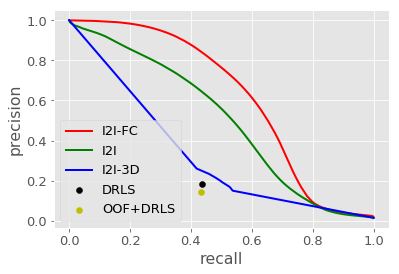

In [15]:
plt.figure()
plt.plot(ERRORS['i2ifc']['pr_'][1], ERRORS['i2ifc']['pr_'][0], color='r', linewidth=2, label='I2I-FC')
plt.plot(ERRORS['i2i']['pr_'][1], ERRORS['i2i']['pr_'][0], color='g', linewidth=2, label='I2I')
plt.plot(ERRORS['i2i3d']['pr_'][1], ERRORS['i2i3d']['pr_'][0], color='b', linewidth=2, label='I2I-3D')
plt.scatter(ERRORS['drls']['pr'][1][1:-1], ERRORS['drls']['pr'][0][1:-1], color='k', label='DRLS')
plt.scatter(ERRORS['drls_oof']['pr'][1][1:-1], ERRORS['drls_oof']['pr'][0][1:-1], color='y', label='OOF+DRLS')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()
plt.savefig('pr.pdf',dpi=600)
plt.show()